In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
try: 
    import vocab
except ImportError:
    import sys
    sys.path.insert(0, '/Users/mbaumer/side_projects/ruth-bader-ginsbot/python/')
    import vocab
import keras

/Users/mbaumer/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = pd.read_csv('../data/supreme_court_dialogs_corpus_v1.01/supreme.conversations.txt',sep='\ \+\+\+\$\+\+\+\ ',
            names=['case_id','utterance_id','after_previous','speaker','isJustice','justice_vote','presenting_side','utterance'])

/Users/mbaumer/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [3]:
data['justice_vote'][0]

'PETITIONER'

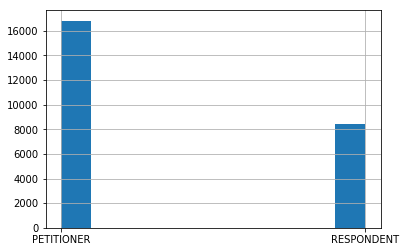

In [4]:
justice_lines = data[(data['isJustice'] == 'JUSTICE') & ((data['justice_vote'] == 'PETITIONER') | (data['justice_vote'] == 'RESPONDENT'))]
justice_lines['justice_vote'].hist()

(array([1.9791e+04, 3.9040e+03, 1.1020e+03, 2.9100e+02, 1.1600e+02,
        3.9000e+01, 1.5000e+01, 8.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  2. ,  53.9, 105.8, 157.7, 209.6, 261.5, 313.4, 365.3, 417.2,
        469.1, 521. ]),
 <a list of 10 Patch objects>)

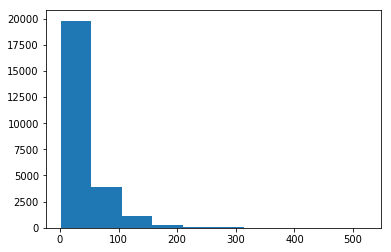

In [5]:
tokens = map(nltk.word_tokenize,justice_lines['utterance'])
plt.hist(map(len,tokens))

In [6]:
max_utterance_length = 200

In [7]:
justice_lines.groupby(['case_id','speaker']).first()['justice_vote']

case_id   speaker                
02-1472   JUSTICE BREYER             PETITIONER
          JUSTICE GINSBURG           PETITIONER
          JUSTICE KENNEDY            PETITIONER
          JUSTICE O'CONNOR           PETITIONER
          JUSTICE SCALIA             PETITIONER
          JUSTICE SOUTER             PETITIONER
          JUSTICE STEVENS            PETITIONER
02-1672   JUSTICE BREYER             PETITIONER
          JUSTICE GINSBURG           PETITIONER
          JUSTICE KENNEDY            RESPONDENT
          JUSTICE O'CONNOR           PETITIONER
          JUSTICE SCALIA             RESPONDENT
          JUSTICE SOUTER             PETITIONER
          JUSTICE STEVENS            PETITIONER
03-10198  CHIEF JUSTICE REHNQUIST    PETITIONER
          JUSTICE BREYER             PETITIONER
          JUSTICE GINSBURG           PETITIONER
          JUSTICE KENNEDY            PETITIONER
          JUSTICE O'CONNOR           PETITIONER
          JUSTICE SCALIA             RESPONDENT
      

In [8]:
len(justice_lines['justice_vote'])

25273

In [9]:
emb_matrix, word2id, id2word = vocab.get_glove('/Users/mbaumer/side_projects/ruth-bader-ginsbot/data/glove/glove.6B.50d.txt',50)

  1%|          | 4290/400000 [00:00<00:09, 42885.42it/s]

Loading GLoVE vectors from file: /Users/mbaumer/side_projects/ruth-bader-ginsbot/data/glove/glove.6B.50d.txt


100%|██████████| 400000/400000 [00:08<00:00, 46286.48it/s]


In [10]:
N_words = 0
N_unk = 0
list_list_tokens = []
for sentence in tokens:
    list_tokens = []
    for word in sentence:
        N_words += 1
        token_id = word2id.get(word,1)
        list_tokens.append(token_id)
        if token_id == 1:
            N_unk += 1
    list_list_tokens.append(list_tokens)
print 'Nwords:', N_words
print 'Nunk:', N_unk
print '%unk:', N_unk/N_words*100

Nwords: 904359
Nunk: 85233
%unk: 9.42468643536


In [11]:
len(list_list_tokens)

25273

In [12]:
y = np.zeros(len(justice_lines))
y[np.where(justice_lines['justice_vote'] == 'PETITIONER')] = 1

In [13]:
shuffled = np.random.permutation(np.arange(len(justice_lines),dtype=int))
train_inds = shuffled[:int(len(justice_lines)*.7)]
test_inds = shuffled[int(len(justice_lines)*.7):]

In [14]:
len(train_inds)+len(test_inds) == len(justice_lines)

True

In [15]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, Bidirectional
from keras.datasets import imdb

max_features = len(word2id)
maxlen = 200
batch_size = 128

print('Loading data...')
x_train = [list_list_tokens[train_ind] for train_ind in train_inds]
y_train = y[train_inds]
x_test = [list_list_tokens[test_ind] for test_ind in test_inds]
y_test = y[test_inds]
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
17691 train sequences
7582 test sequences
Pad sequences (samples x time)
x_train shape: (17691, 200)
x_test shape: (7582, 200)
Build model...
Train...
Train on 17691 samples, validate on 7582 samples
Epoch 1/2
17691/17691 [==============================] - 544s 31ms/step - loss: 0.6399 - acc: 0.6630 - val_loss: 0.6349 - val_acc: 0.6668
Epoch 2/2
7582/7582 [==============================] - 36s 5ms/step
Test score: 0.6244640010574882
Test accuracy: 0.6707992615029353


In [16]:
from sklearn.metrics import roc_curve

In [17]:
y_pred = model.predict(x_train)

In [18]:
y_pred_test = model.predict(x_test)

In [19]:
fpr,tpr, _ = roc_curve(y_train,y_pred)
fpr1,tpr1, _ = roc_curve(y_train,np.ones_like(y_train))
fpr2,tpr2, _ = roc_curve(y_test,y_pred_test)

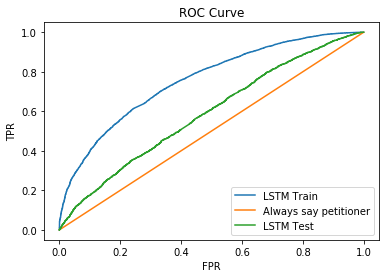

In [20]:
plt.plot(fpr,tpr,label='LSTM Train')
plt.plot(fpr1,tpr1,label='Always say petitioner')
plt.plot(fpr2,tpr2,label='LSTM Test')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

In [21]:
print ('Results from always saying Petitioner:',np.sum(y)/len(y))

Results from always saying Petitioner: 0.6650575713211728


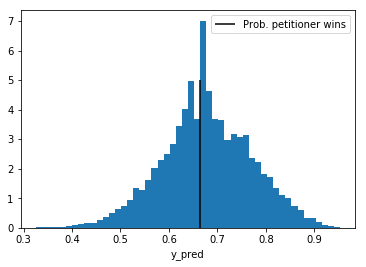

In [22]:
plt.hist(y_pred,normed=True,bins=50)
plt.xlabel('y_pred');
plt.vlines(np.sum(y)/len(y),0,5,label='Prob. petitioner wins')
plt.legend()

In [23]:
out = justice_lines.iloc[train_inds]

In [24]:
out['pred'] = pd.Series(y_pred.flatten(),index=out.index)

/Users/mbaumer/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
stats = out[['case_id','speaker','justice_vote','pred']].groupby(['case_id','speaker'])

In [26]:
marker = stats.agg({'justice_vote' :'first', 'pred':'mean'})['justice_vote'].values == 'PETITIONER'
ynew = marker.astype('int')

In [27]:
yhat_new = stats.agg({'justice_vote' :'first', 'pred':'mean'})['pred'].values

In [31]:
stats.mean()['pred'].values

array([0.72466666, 0.77021384, 0.72099406, ..., 0.76463354, 0.75415355,
       0.7503021 ], dtype=float32)

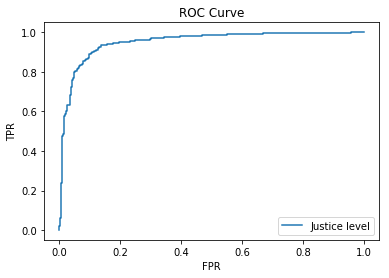

In [32]:
fpr3,tpr3, _ = roc_curve(ynew,yhat_new)
#plt.plot(fpr,tpr,label='LSTM Train')
#plt.plot(fpr1,tpr1,label='Always say petitioner')
#plt.plot(fpr2,tpr2,label='LSTM Test')
plt.plot(fpr3,tpr3,label='Justice level')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

In [33]:
out = justice_lines.iloc[test_inds]
out['pred'] = pd.Series(y_pred_test.flatten(),index=out.index)
stats = out[['case_id','speaker','justice_vote','pred']].groupby(['case_id','speaker'])
marker = stats.agg({'justice_vote' :'first', 'pred':'mean'})['justice_vote'].values == 'PETITIONER'
ynew_test = marker.astype('int')
yhat_new_test = stats.agg({'justice_vote' :'first', 'pred':'mean'})['pred'].values

/Users/mbaumer/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


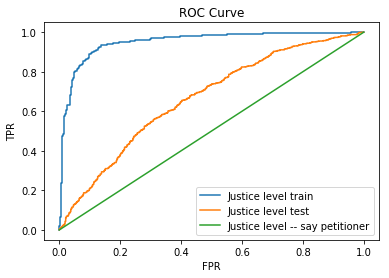

In [35]:
fpr3,tpr3, _ = roc_curve(ynew,yhat_new)
fpr4,tpr4, thresholds = roc_curve(ynew_test,yhat_new_test)
fpr5,tpr5, _ = roc_curve(ynew_test,np.ones_like(ynew_test))
plt.plot(fpr3,tpr3,label='Justice level train')
plt.plot(fpr4,tpr4,label='Justice level test')
plt.plot(fpr5,tpr5,label='Justice level -- say petitioner')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

In [44]:
fpr[2500]

0.31301565920188584

In [45]:
thresholds

array([0.9077762 , 0.8530423 , 0.83008057, 0.8297581 , 0.82536507,
       0.8101057 , 0.8084018 , 0.80711263, 0.8057738 , 0.80323905,
       0.80251354, 0.79390234, 0.7924292 , 0.79123235, 0.78913784,
       0.78661287, 0.78516424, 0.78079295, 0.780208  , 0.7729609 ,
       0.77290946, 0.7605444 , 0.7593608 , 0.75647634, 0.75642705,
       0.75611484, 0.75495166, 0.7544774 , 0.7539599 , 0.75230294,
       0.75219905, 0.7502364 , 0.7501852 , 0.750181  , 0.75009537,
       0.7486415 , 0.74782646, 0.7451143 , 0.7451056 , 0.7434633 ,
       0.7429913 , 0.7422848 , 0.7420994 , 0.74087965, 0.74086726,
       0.74009234, 0.7397572 , 0.73972243, 0.7390935 , 0.7382694 ,
       0.73771775, 0.7364746 , 0.73638153, 0.7361053 , 0.7358934 ,
       0.73552525, 0.73530656, 0.73470104, 0.7343978 , 0.73387873,
       0.73369783, 0.73208827, 0.732033  , 0.73178756, 0.73146   ,
       0.73104894, 0.7303052 , 0.72973627, 0.72946787, 0.7290106 ,
       0.72900236, 0.72898513, 0.7285149 , 0.72776246, 0.72764

In [57]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [72]:
post_threshold = np.zeros_like(yhat_new_test)
post_threshold[np.where(yhat_new_test > .63)] = 1
confusion_matrix(ynew_test,post_threshold,)

array([[128, 348],
       [ 82, 840]])

In [73]:
accuracy_score(ynew_test,post_threshold)

0.6924177396280401